In [113]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt

In [92]:
def sigmoidf (X):
    return  1 / (1 + np.exp(-X))

In [101]:
#load the data
def load():
    df = pd.read_csv (r'spambase.data',header=None)
    return df

In [102]:
def scale(df):
#scale the data to [0-1] range
    col=df.columns
    v = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    v_scaled = min_max_scaler.fit_transform(v)
    df = pd.DataFrame(v_scaled, columns=col)
    return df

In [139]:
def splits(df):
#randomly split the train and test datasets
    kf =  RepeatedKFold(n_splits=5, n_repeats=1)
    #kf =  RepeatedKFold(n_splits=5, n_repeats=1, random_state=12883823)
    df_train_l=[]
    df_test_l=[]
    for train, test in kf.split(df):
        df_train_l.append(train.reshape(-1,1))
        df_test_l.append(test.reshape(-1,1))
    return df_train_l,df_test_l


In [140]:
def getXandY(ind,df):
    #separate the data and the labels
    df=df.to_numpy()
    df=df[ind]
    Y=df[:,0,57]
    X=df[:,0,0:57]
    return X,Y

In [141]:
def calculateW(X_train,Y_train):
    #find X1[part of the train data that has label Y=0],X2 [part of the train data that has label Y=1]
    X1=X_train[Y_train<0.5]
    X2=X_train[Y_train>0.5]
    #find the number of data points where y=0 , and y=1 
    N1=X1.shape[0]
    N2=X2.shape[0]
    N=N1+N2
    #find the Mean vecors M1 [mean of features for all the data points in Y=0]
    # and M2 [mean of features for all the data points in Y=1]
    M1=(1/N1)* np.sum(X1, axis=0,keepdims=True)
    M2=(1/N2)* np.sum(X2, axis=0,keepdims=True)
    #find the covariance matrix and its inverse
    X1_mins_M1=np.sum((X1-M1), axis=0,keepdims=True)
    X2_mins_M2=np.sum((X2-M2), axis=0,keepdims=True)

    S1=(1/N1)*np.dot(X1_mins_M1.T,X1_mins_M1)
    S2=(1/N2)* np.dot(X2_mins_M2.T,X2_mins_M2)

    cov=(N1/N)*S1+ (N2/N)*S2
    covinv=np.linalg.inv(cov)
    #finding the weights W and W0
    W= np.dot(covinv,(M1-M2).T)
    Pc1=N1/N
    Pc2=N2/N
    W0=(-1/2)*np.dot(np.dot(M1,covinv),M1.T) + (1/2)*np.dot(np.dot(M2,covinv),M2.T) + math.log((Pc1/Pc2),10)
    #now the model is sigmoid(WT.X+W0)
    return W, W0

In [142]:
def model(X_test,W,W0):
    Y_pred=sigmoidf(np.dot(W.T,X_test.T)+W0)
    Y_pred=Y_pred.astype(int)
    Y_pred=Y_pred.T
    return Y_pred

In [143]:
#calculating the accuracy and the confudion matrix
def evaluation(Y_test,Y_pred):
    accuracy=accuracy_score(Y_test, Y_pred)
    conf=confusion_matrix(Y_test,  Y_pred)
    return accuracy,conf

In [144]:
def plot_accuracy(train_acc_l,test_acc_l):
    x= [i for i in range(1,6)]
    plt.plot(x, train_acc_l , 'b^',linestyle='-',label='train acc')
    plt.plot(test_acc_l , 'g+',linestyle='-',label='test_acc')
    plt.xlabel('k folds')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

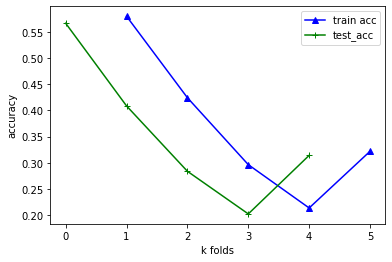

train_acc [0.5801630434782609, 0.42434121162727517, 0.29638685139907633, 0.21352893235533824, 0.32192339038304807]
test_acc [0.5667752442996743, 0.40869565217391307, 0.28369565217391307, 0.20217391304347826, 0.3141304347826087]
avg_acc_train 0.36726868584859973
avg_acc_test 0.35509417929471754


In [148]:
#main

df=load()
df=scale(df)
df_train_l,df_test_l=splits(df)
train_acc_l=[]
train_conf_l=[]
test_acc_l=[]
test_conf_l=[]
for i in range (len(df_train_l)):
    df_train=df_train_l[i]
    df_test=df_test_l[i]
    X_train,Y_train=getXandY(df_train,df)
    X_test,Y_test=getXandY(df_test,df)
    W,W0=calculateW(X_train,Y_train)
    Y_train_pred=model(X_train,W,W0)
    Y_test_pred=model(X_test,W,W0)
    train_acc,train_conf=evaluation(Y_train,Y_train_pred)
    test_acc,test_conf=evaluation(Y_test,Y_test_pred)
    train_acc_l.append(train_acc)
    train_conf_l.append(train_conf)
    test_acc_l.append(test_acc)
    test_conf_l.append(test_conf)
avg_acc_train=sum(train_acc_l)/5
avg_acc_test=sum(test_acc_l)/5

plot_accuracy(train_acc_l,test_acc_l)
print("train_acc",train_acc_l)
print("test_acc",test_acc_l)
print("avg_acc_train",avg_acc_train)
print("avg_acc_test",avg_acc_test)